In [1]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression

# Import des données

In [2]:
df = pd.read_csv("./data/GNP.csv")

In [3]:
df["GR_GNP"] = np.log(df['GNP']).diff()*100
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.iloc[1:]

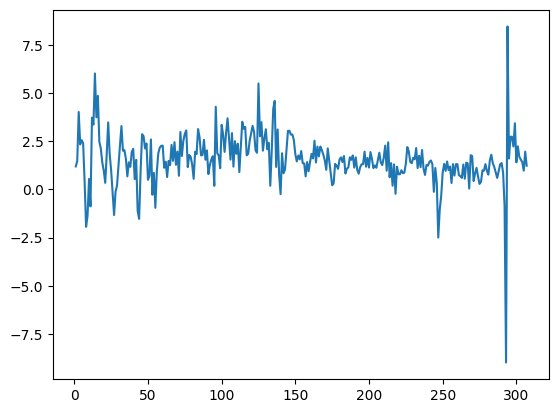

In [4]:
plt.plot(df["GR_GNP"])

# Visualisations des crises

In [5]:
usrec = DataReader("USREC", 
                   "fred", 
                   start=datetime(1947, 1, 1), 
                   end=datetime(2023, 10, 1))

usrec.index = pd.to_datetime(usrec.index)

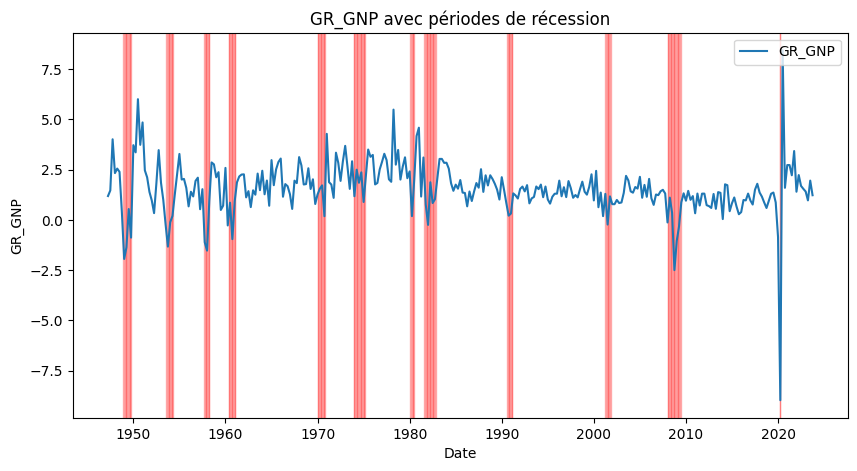

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(df.DATE, df["GR_GNP"], label='GR_GNP')

for period in usrec.loc[usrec['USREC'] == 1].index.to_series().groupby((usrec['USREC'] == 1).cumsum()).agg(['first','last']).itertuples():
    plt.axvspan(period.first, period.last, color='red', alpha=0.3)

plt.title("GR_GNP avec périodes de récession")
plt.xlabel("Date")
plt.ylabel("GR_GNP")
plt.legend()
plt.show()

# Modélisation - Modèle AutoRegression

In [31]:
train = df.iloc[:round(len(df)*0.9)]
test = df.iloc[round(len(df)*0.9):]

In [32]:
mar_model = MarkovAutoregression(train['GR_GNP'], k_regimes=2, order=2, switching_ar=False, switching_variance=True)
mar_res = mar_model.fit()

In [33]:
print(mar_res.summary())

                         Markov Switching Model Results                         
Dep. Variable:                   GR_GNP   No. Observations:                  274
Model:             MarkovAutoregression   Log Likelihood                -343.026
Date:                  Wed, 01 May 2024   AIC                            702.053
Time:                          16:34:23   BIC                            730.958
Sample:                               0   HQIC                           713.655
                                  - 274                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5510      0.119     12.991      0.000       1.317       1.785
sigma2         0.3000      0.052    

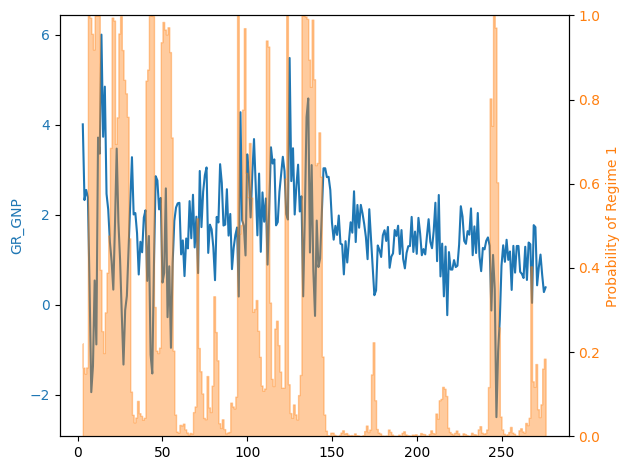

In [35]:
smoothed_marginal_probabilities = mar_res.smoothed_marginal_probabilities

# Plot the series and the smoothed probabilities
fig, ax1 = plt.subplots()

ax1.plot(train.iloc[2:].index, train.iloc[2:]['GR_GNP'], label='GR_GNP')
ax1.set_ylabel('GR_GNP', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.fill_between(train.iloc[2:].index, smoothed_marginal_probabilities[1], step='pre', alpha=0.4, color='C1')
ax2.set_ylabel('Probability of Regime 1', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_ylim([0, 1])

fig.tight_layout()
plt.show()

In [36]:
import numpy as np

p00, p10, const0, const1, sigma0, sigma1, ar1_L1, ar1_L2 = mar_res.params
log_odds = np.array([const0, const1])
diff_log_odds = np.array([log_odds[i] - log_odds[j] for i in range(len(log_odds)) for j in range(len(log_odds))])

transition_probs = np.exp(diff_log_odds) / (1 + np.exp(diff_log_odds))

transition_matrix = np.array([transition_probs[i:i+len(log_odds)] for i in range(0, len(transition_probs), len(log_odds))])

transition_matrix /= np.sum(transition_matrix, axis=1)[:,None]

transition_matrix

array([[0.40253042, 0.59746958],
       [0.34024568, 0.65975432]])

On a 38% de chance de rester en régime 0 si on est en régime 0, 61% de passer en régime 1. On a 29% de chance de passze en régime 0 si on est en régime 1, 70% de rester en régime 1. 

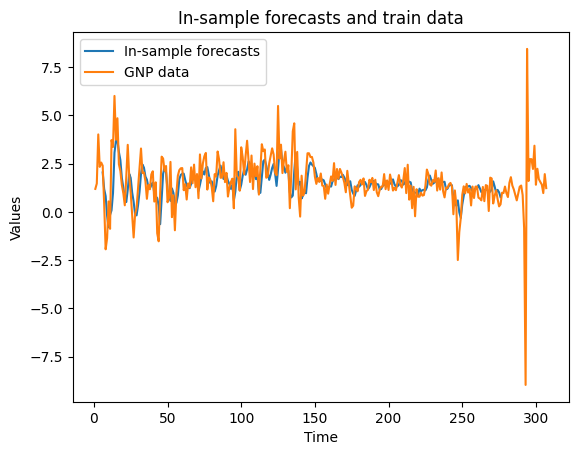

In [37]:
in_sample_forecasts = mar_res.predict()

# Plot the data
plt.plot(in_sample_forecasts, label='In-sample forecasts')
plt.plot(df['GR_GNP'], label='GNP data')

# Add axis labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('In-sample forecasts and train data')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [39]:
predicted_states = mar_res.predicted_marginal_probabilities

In [62]:
train['GR_GNP'].values[-1]

0.38917054891136615

In [63]:
ar_params = mar_res.params['ar.L1'], mar_res.params['ar.L2']

# Variances pour chaque régime (différentes car switching_variance=True)
sigma1 = mar_res.params['sigma2[0]']
sigma2 = mar_res.params['sigma2[1]']

last_value1 = train['GR_GNP'].values[-1]  # Valeur la plus récente
last_value2 = train['GR_GNP'].values[-2]  # Deuxième valeur la plus récente

# Prévoir pour chaque point dans vos données de test
forecast = []
for probs in predicted_states:
    mean_forecast = (probs[0] * (ar_params[0] * last_value1 + ar_params[1] * last_value2) +
                     probs[1] * (ar_params[0] * last_value1 + ar_params[1] * last_value2))
    forecast.append(mean_forecast)

    # Mettre à jour les dernières valeurs pour la prochaine itération
    last_value2 = last_value1
    last_value1 = mean_forecast

TypeError: 'int' object is not subscriptable

# Modélisation - Modèle Regression

In [14]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

model2 = MarkovRegression(df['GR_GNP'], k_regimes=2, trend='c', switching_variance=True)
model2fitted = model2.fit()

In [15]:
print(model2fitted.summary())

                        Markov Switching Model Results                        
Dep. Variable:                 GR_GNP   No. Observations:                  307
Model:               MarkovRegression   Log Likelihood                -435.821
Date:                Sat, 27 Apr 2024   AIC                            883.642
Time:                        18:41:08   BIC                            906.003
Sample:                             0   HQIC                           892.584
                                - 307                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3332      0.045     29.680      0.000       1.245       1.421
sigma2         0.2756      0.035      7.914      0.0

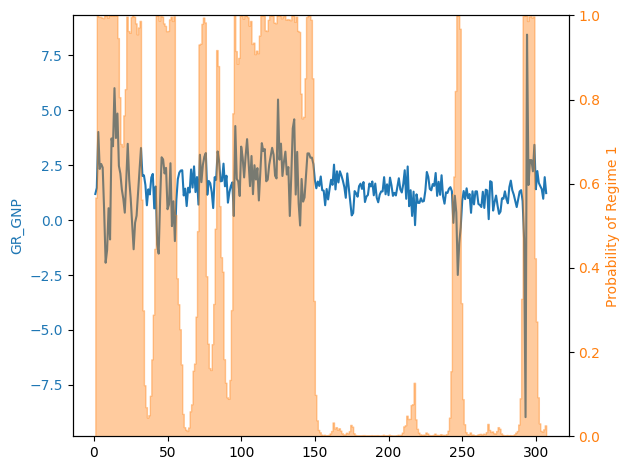

In [16]:
smoothed_marginal_probabilities = model2fitted.smoothed_marginal_probabilities

# Plot the series and the smoothed probabilities
fig, ax1 = plt.subplots()

ax1.plot(df.index, df['GR_GNP'], label='GR_GNP')
ax1.set_ylabel('GR_GNP', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.fill_between(df.index, smoothed_marginal_probabilities[1], step='pre', alpha=0.4, color='C1')
ax2.set_ylabel('Probability of Regime 1', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_ylim([0, 1])

fig.tight_layout()
plt.show()

In [17]:
import numpy as np

p00, p10, const0, const1, sigma0, sigma1 = model2fitted.params
log_odds = np.array([const0, const1])
diff_log_odds = np.array([log_odds[i] - log_odds[j] for i in range(len(log_odds)) for j in range(len(log_odds))])

transition_probs = np.exp(diff_log_odds) / (1 + np.exp(diff_log_odds))

transition_matrix = np.array([transition_probs[i:i+len(log_odds)] for i in range(0, len(transition_probs), len(log_odds))])

transition_matrix /= np.sum(transition_matrix, axis=1)[:,None]

transition_matrix

array([[0.57152192, 0.42847808],
       [0.55561201, 0.44438799]])

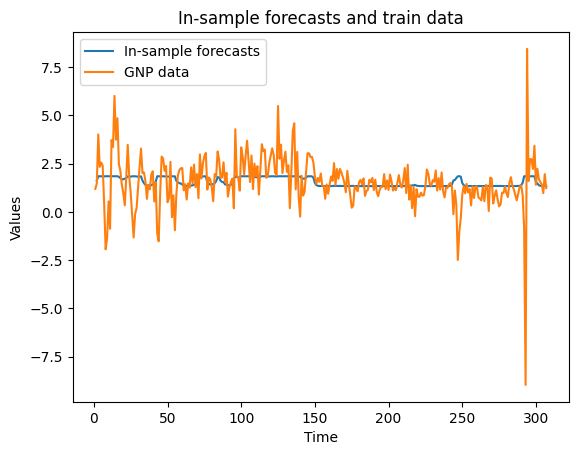

In [19]:
in_sample_forecasts = model2fitted.predict()

# Plot the data
plt.plot(in_sample_forecasts, label='In-sample forecasts')
plt.plot(df['GR_GNP'], label='GNP data')

# Add axis labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('In-sample forecasts and train data')

# Add legend
plt.legend()

# Show the plot
plt.show()

# Modélisation - Modèles à états cachés

In [24]:
from hmmlearn import hmm

def calculate_bic(n_components, series):
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000).fit(series.reshape(-1, 1))
    log_likelihood = model.score(series.reshape(-1, 1))
    n_params = n_components**2 + 2 * n_components * series.shape[0] - 1
    bic = np.log(len(series)) * n_params - 2 * log_likelihood
    return bic

bics = [calculate_bic(n, df["GR_GNP"].values) for n in range(1, 10)]
best_n_components = np.argmin(bics) + 1

In [25]:
best_n_components

1

In [26]:
bics

[4547.168473930329,
 7942.382192563255,
 11406.572511321818,
 14946.365913337439,
 18514.163549744135,
 22094.87840118451,
 25649.557028314648,
 29220.125883180357,
 32825.40851842362]

In [33]:
best_model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000)
best_model.fit(df["GR_GNP"].values.reshape(-1, 1))

GaussianHMM(n_components=2, n_iter=1000)

In [34]:
states = best_model.predict(df["GR_GNP"].values.reshape(-1, 1))

In [36]:
states.sum()

186